# Ferguson Climate Calculator

In this notebook the Ferguson family will establish our best understanding of the most critical climate change issues.

Perhaps the most central data to this discussion is atmospheric concentration of carbon dioxide, which we can access via the datahub.io website. We will use parts per million by volume (ppmv) as the unit to measure concentration.

We can pull in that data from the datahub.io website and convert it to python arrays which we can then analyze by a two step process. (1) Load python code libraries that give us access to functions for importing data from websources and (2) Load python code libraries that allows us to analyze the data.

In [1]:
# Import the needed code libraries
from datapackage import Package # code to import data from website repositories.
import matplotlib.pyplot as plt # code used for plotting data
from scipy.optimize import curve_fit # code used for fitting data
import numpy as np # code use for processing data

In [2]:
# Import CO2 concentration data
package = Package('https://datahub.io/core/co2-ppm/datapackage.json')

# extract CO2 concentration data from the package 
co2_mm_mlo = package.resources[1]

# extract the date of the CO2 concentration reading
decimal_year = np.array([
  float(row[1]) 
  for row in co2_mm_mlo.read()
  ])

# extract the CO2 concentration reading
co_concentration = np.array([
  float(row[2]) 
  for row in co2_mm_mlo.read()
  ])

# Seems to be some weird unphysical negative readings, so let's eliminate those.
d_year_array = []
co_array = []

for d_year, co in zip(decimal_year, co_concentration):
    if 0 < co:
        d_year_array += [d_year]
        co_array += [co]
        
d_year_array = np.array(d_year_array)
co_array = np.array(co_array)

Now that we have imported the raw data let's plot it using the matplotlib function library we imported.

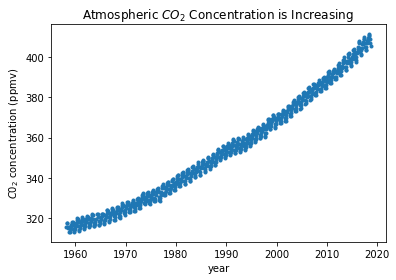

In [3]:
plt.figure()
plt.title('Atmospheric $CO_2$ Concentration is Increasing')
plt.plot(d_year_array, co_array, '.')
plt.xlabel('year')
plt.ylabel('$C0_2$ concentration (ppmv)')
plt.show()

## Fitting the data

To understand the data lets fit it to the following model function: `model_func(y)` 

\begin{align}
model\_func(y) = C_0 + A \cos(2\pi(y-y_s)) + C \, (1+r)^{\left( y-y_0 \right)}
\end{align}

The model functions combines three effects, a constant term, an oscilating term to account for the global seasonal varriations, and an expoentially growing term. 

For simplicity we shift the data relative to a reference year which we choose to be 1900: So y0 = 1900. If a different reference year was picked this would shift the value of $C$, but would otherwise not alter the equations.

In [4]:
y0 = 1900

The other parameters in the function will be fit to the data to find their optimal values. They are:
- $C_0$ : a baseline concentration of $CO_2$.
- $A$ : the amplitude of seasonal oscillations of $CO_2$ (more trees in northern hemisphere)
- $y_s$: a shift to align the seasons to the proper time of year
- $C$ : the concentration of $CO_2$ due to an additional source in the reference year. 
- $r$ : the growth rate per year for the additional $CO_2$ contribution.

An initial guess for these parameters need to be given so that the optimization routine can converge.

In [5]:
C0 = 240 
A = 4
y_s = .5
C = 20
r = .02

# group these parameters into a list
p0 = [C0 , A, y_s, C, r]

We now define the fit function, and use curve_fit function important from scipy to find the optimal parameters `p_opt`.

In [6]:
def model_func(dec_year, C0 , A, y_s, C, r):
    out = C0 + C*(1+r)**(dec_year-y0) + A*np.cos(2*np.pi*(dec_year - y_s))
    return out

p_opt, p_cov = curve_fit(model_func, d_year_array, co_array, p0=p0)
# set our parameters to the optimal fit ones
[C0 , A, y_s, C, r] = p_opt

We can then plot the data and the model and see that there is good agreement.

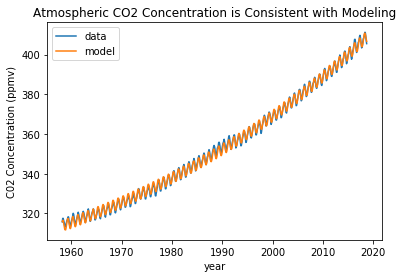

In [7]:
plt.figure()
plt.title('Atmospheric CO2 Concentration is Consistent with Modeling')
plt.plot(d_year_array, co_array, label='data')
plt.plot(d_year_array, model_func(d_year_array, C0 , A, y_s, C, r), label='model')
plt.legend()
plt.xlabel('year')
plt.ylabel('C02 Concentration (ppmv)')
plt.show()

The formula to calculate the double time from the growth rate is

$ \Delta y = 1/log_2(1+r) $

Our initial conclusions from the data is:

In [8]:
print('Baseline CO2 concentration is '+str(np.round(C0,0))[0:3]+' (ppmv).')
print('Amplitude of seasonal CO2 concentration oscillations is '+str(np.round(A,2))[0:5]+' (ppmv).')
print('CO concentration of additional contribution in '+str(y0)+' is '+str(np.round(C,1))[0:4]+' (ppmv).')
print('Growth rate per year of exponential contribution to CO2 is '+str(np.round(100*r,2))[0:5]+"%")
print('Doubling time of additional contribution is '+str(np.round(1/np.log2(1+r),1))[0:5]+' years.')

Baseline CO2 concentration is 256 (ppmv).
Amplitude of seasonal CO2 concentration oscillations is 2.84 (ppmv).
CO concentration of additional contribution in 1900 is 22.2 (ppmv).
Growth rate per year of exponential contribution to CO2 is 1.63%
Doubling time of additional contribution is 42.7 years.
